Import module

In [2]:
import numpy as np # linear algebra
import nilearn as nl
import nilearn.plotting as nlplt
import nibabel as nib
import h5py
import matplotlib.pyplot as plt
from nilearn.image import load_img
import numpy as np
import cv2
import math 

Load Nii format data

In [3]:
subject_filename = '/home/bk/Desktop/EPI2T1/filtered2hires_exam.nii.gz'
smri_filename = '/home/bk/Desktop/EPI2T1/primeRecon_02_t1_mprage_brain.nii.gz'

In [4]:
smri_img = nl.image.load_img(smri_filename)
func_img = nl.image.load_img(subject_filename)
anat = smri_img.get_fdata()
func = func_img.get_fdata()

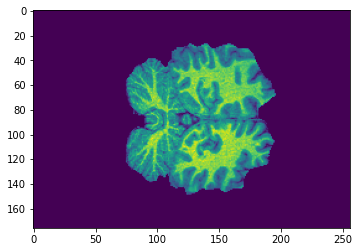

In [5]:
plt.imshow(anat[:, 80, :])

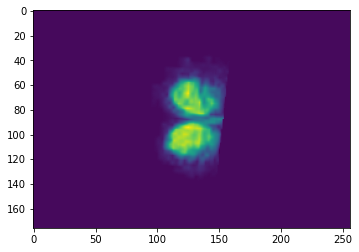

In [6]:
plt.imshow(func[:, 50, :])

Definition of some functions

In [7]:
## hough transform
def HoughTransform(img):
    img[np.where(img < 1)] = 0
    img_tmp = img.copy()
    img_tmp[np.where(img > 1)] = 255
    img = np.uint8(img)
    img_tmp = np.uint8(img_tmp)
    #cv2.imshow('Original',img)

    edges = cv2.Canny(img_tmp,250,500,apertureSize = 3)
    #cv2.imshow('Edges',edges)
    lines = cv2.HoughLines(edges,1,np.pi/180,70)

    img_bg = np.zeros([img.shape[0], img.shape[1], 3])
    img_bg[:, :, 0] = img 
    img_bg[:, :, 1] = img
    img_bg[:, :, 2] = img
    img_bg = np.uint8(img_bg)
    #cv2.imshow('Canvas Img',img_bg)

    for rho,theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        #img = np.float32(img)
        cv2.line(img_bg, (x1, y1), (x2, y2), (0, 0, 255), 2)
    #cv2.imshow('Line Detection',img_bg)
    theta_c = theta.copy()

    return theta_c

## obtain rotation matrix
def MRImgRotation(theta, img, view, t):
    if view == 'coronal':
        rot_deg_column = math.degrees(theta) + 90
        # grab the dimensions of the image and calculate the center of the image
        tmpimg_c = img[:, 0, :]
        (h_col, w_col) = tmpimg_c.shape[:2]
        (cX_col, cY_col) = (w_col / 2, h_col / 2)
 
        # rotate our image by 45 degrees
        M_column = cv2.getRotationMatrix2D((cX_col, cY_col), rot_deg_column, 1.0)
        #rotated = cv2.warpAffine(img, M, (w, h))
        #cv2.imshow("Rotated by 45 Degrees", rotated)

        ## volume rotation, column wise
        func_rot_result = np.zeros(img.shape)
        for c_index in range(0,img.shape[1]):
            if t == 'func':
                tmpimg_c = img[:, c_index, :]/256
            elif t == 'anat':
                tmpimg_c = img[:, c_index, :]/64
            tmpimg_c = np.uint8(tmpimg_c)
            func_rot_result[:,c_index,:] = cv2.warpAffine(tmpimg_c, M_column, (w_col, h_col))

    elif view == 'sagital':
        rot_deg_frame = math.degrees(theta) + 270
        # grab the dimensions of the image and calculate the center of the image
        tmpimg_s = img[:, :, 0]
        (h_frame, w_frame) = tmpimg_s.shape[:2]
        (cX_frame, cY_frame) = (w_frame / 2, h_frame / 2)
 
        # rotate our image by 45 degrees
        M_frame = cv2.getRotationMatrix2D((cX_frame, cY_frame), rot_deg_frame, 1.0)
        #rotated = cv2.warpAffine(img, M, (w, h))
        #cv2.imshow("Rotated by 45 Degrees", rotated)
      
        ## rotation, row wise
        for f_index in range(0, img.shape[2]):  
            tmpimg_s = img[:, :, f_index]
            tmpimg_s = np.uint8(tmpimg_s)
            img[:, :, f_index] = cv2.warpAffine(tmpimg_s, M_frame, (w_frame, h_frame))
        
        func_rot_result = img
    
    else:
        print('checking view parameter!')
        
    return func_rot_result

Image Transformation, This part is recomended with spyder.

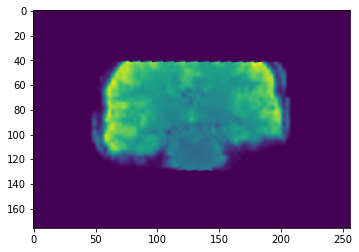

In [8]:
#%%func image     
##########coronal view#####################
img_cor = func[:, 120, :] / 256
theta_c = HoughTransform(img_cor)
func_rot_c = MRImgRotation(theta_c, func, 'coronal', 'func')
plt.imshow(func_rot_c[:, 120, :])

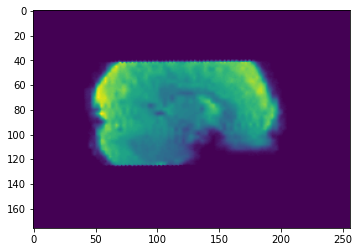

In [9]:
###########sagital view#####################
img_sag = func_rot_c[:, :, 120]
theta_s = HoughTransform(img_sag)
func_rot_c_s = MRImgRotation(theta_s, func_rot_c, 'sagital', 'func')
func_rot_c_s = cv2.normalize(func_rot_c_s, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(func_rot_c_s[:, :, 120])

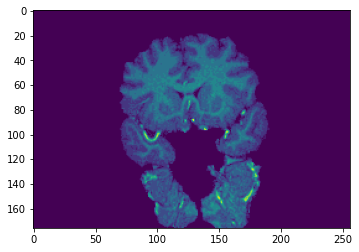

In [10]:
#%%anat image
##########coronal view#####################
anat_rot_c = MRImgRotation(theta_c, anat, 'coronal', 'anat')
plt.imshow(anat_rot_c[:, 150, :])

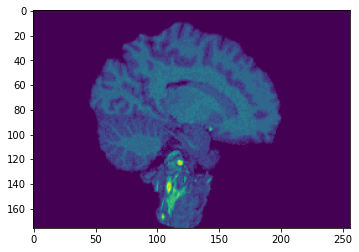

In [11]:
###########sagital view#####################
anat_rot_c_s = MRImgRotation(theta_s, anat_rot_c, 'sagital', 'anat')
anat_rot_c_s = cv2.normalize(anat_rot_c_s, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(anat_rot_c_s[:, :, 110])

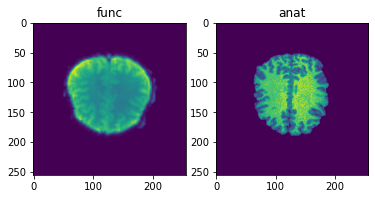

In [19]:
#ploting
slice_num = 50

plt.subplot(1, 2, 1)
plt.title('func')
plt.imshow(func_rot_c_s[slice_num, :, :])
plt.subplot(1, 2, 2)
plt.title('anat')
plt.imshow(anat_rot_c_s[slice_num, :, :])  
plt.show()
 